In [2]:
import optuna
import os

# Ruta a tu base de datos Optuna (ajustá si es necesario)
db_path = "../../../buckets/b1/Compe_02/optuna_db/TEST 1 - Modelo Final  - Pruebo Learning Rate con funcionamiento variable.db"

# Verificar que el archivo exista
if not os.path.exists(db_path):
    raise FileNotFoundError(f"No se encontró el archivo: {db_path}")

# Crear el storage URL (formato SQLite)
storage_url = f"sqlite:///{db_path}"

# Cargar el estudio
study_name = "TEST 1 - Modelo Final  - Pruebo Learning Rate con funcionamiento variable"  # debe coincidir exactamente
study = optuna.load_study(study_name=study_name, storage=storage_url)

# Obtener el mejor trial
best_trial = study.best_trial

# Mostrar resultados
print("Número del mejor trial:", best_trial.number)
print("Valor objetivo:", best_trial.value)
print("Parámetros:")
for k, v in best_trial.params.items():
    print(f"  {k}: {v}")

# Si querés guardarlo como diccionario
mejores_params = dict(best_trial.params)
print("\nDiccionario con los mejores hiperparámetros:")
print(mejores_params)


Número del mejor trial: 4
Valor objetivo: 2147474611.2
Parámetros:
  num_leaves: 23
  min_data_in_leaf: 223
  feature_fraction: 0.6616669584635271
  bagging_fraction: 0.23994377622330532
  num_boost_round: 439
  lr_init: 0.14053552566659705
  lr_decay: 0.9124750514032693

Diccionario con los mejores hiperparámetros:
{'num_leaves': 23, 'min_data_in_leaf': 223, 'feature_fraction': 0.6616669584635271, 'bagging_fraction': 0.23994377622330532, 'num_boost_round': 439, 'lr_init': 0.14053552566659705, 'lr_decay': 0.9124750514032693}


In [1]:
import pandas as pd

# Ruta al archivo
path = "../../../buckets/b1/datasets/competencia_02_crudo.csv.gz"

# Cargar dataset (pandas detecta el gzip automáticamente)
df = pd.read_csv(path)

# --- Información general ---
print("🔹 Dimensiones del dataset:", df.shape)
print("\n🔹 Tipos de datos:")
print(df.dtypes.value_counts())
print("\n🔹 Primeras filas:")
print(df.head())

# --- Descriptivas numéricas ---
print("\n📊 Descriptivas numéricas:")
print(df.describe().T)

# --- Descriptivas categóricas ---
print("\n🔠 Descriptivas categóricas:")
cat_cols = df.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    print(df[cat_cols].describe().T)
else:
    print("No hay columnas categóricas.")

# --- Valores nulos ---
print("\n🚫 Porcentaje de valores nulos por columna:")
print((df.isnull().mean() * 100).sort_values(ascending=False))

🔹 Dimensiones del dataset: (4717958, 154)

🔹 Tipos de datos:
float64    91
int64      63
Name: count, dtype: int64

🔹 Primeras filas:
   numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
0          249221323    201901               1            0         1   
1          249227600    201901               1            0         1   
2          249227813    201901               1            0         0   
3          249231391    201901               1            0         1   
4          249244739    201901               1            0         1   

   cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
0            44                  69          86.33              14610.01   
1            40                 254        2096.06              15905.41   
2            77                 156        1071.07              10295.09   
3            55                 252         979.98               7670.48   
4            64                 296        2724

In [2]:

df["foto_mes"].value_counts()


foto_mes
202108    164822
202107    164596
202106    164313
202105    163917
202104    163418
202103    163109
202102    162155
202101    161527
202012    160997
202011    160250
202010    159169
202009    157805
202008    156461
202007    154984
202006    153102
202005    150792
202004    149350
202003    148798
202002    146660
202001    143464
201912    139980
201911    137996
201910    136010
201909    133757
201908    132143
201907    130268
201906    128734
201905    127202
201904    126538
201903    125967
201902    125401
201901    124273
Name: count, dtype: int64

In [5]:
import pandas as pd
import numpy as np

# Crear df_target a partir de df
df_target = df[['numero_de_cliente','foto_mes']].copy()
df_target = df_target.sort_values(by=['numero_de_cliente','foto_mes'])

# Crear columnas que indican si el cliente sigue en los meses siguientes
df_target['enmes1'] = df_target.groupby('numero_de_cliente')['numero_de_cliente'].shift(-1)
df_target['enmes2'] = df_target.groupby('numero_de_cliente')['numero_de_cliente'].shift(-2)

# Calcular cuántos meses hay por delante (suponiendo que el último mes es 202108)
df_target['mesespordelante'] = 202108 - df_target['foto_mes']

# Clasificación ternaria
df_target['clase_ternaria'] = np.where(
    df_target['mesespordelante'] >= 2,
    np.where(
        (df_target['numero_de_cliente'] == df_target['enmes1']) &
        (df_target['numero_de_cliente'] == df_target['enmes2']),
        'CONTINUA',
        np.where(
            (df_target['numero_de_cliente'] == df_target['enmes1']) & (df_target['enmes2'].isna()),
            'BAJA+2',
            'BAJA+1'
        )
    ),
    np.where(
        (df_target['mesespordelante'] == 1) & (df_target['enmes1'].isna()),
        'BAJA+1',
        ''
    )
)

# Agregar la columna 'clase_ternaria' a df original
df = df.merge(
    df_target[['numero_de_cliente', 'foto_mes', 'clase_ternaria']],
    on=['numero_de_cliente', 'foto_mes'],
    how='left'
)

# Confirmar
print(df['clase_ternaria'].value_counts(dropna=False))


clase_ternaria
CONTINUA    4349938
             328281
BAJA+1        20234
BAJA+2        19505
Name: count, dtype: int64


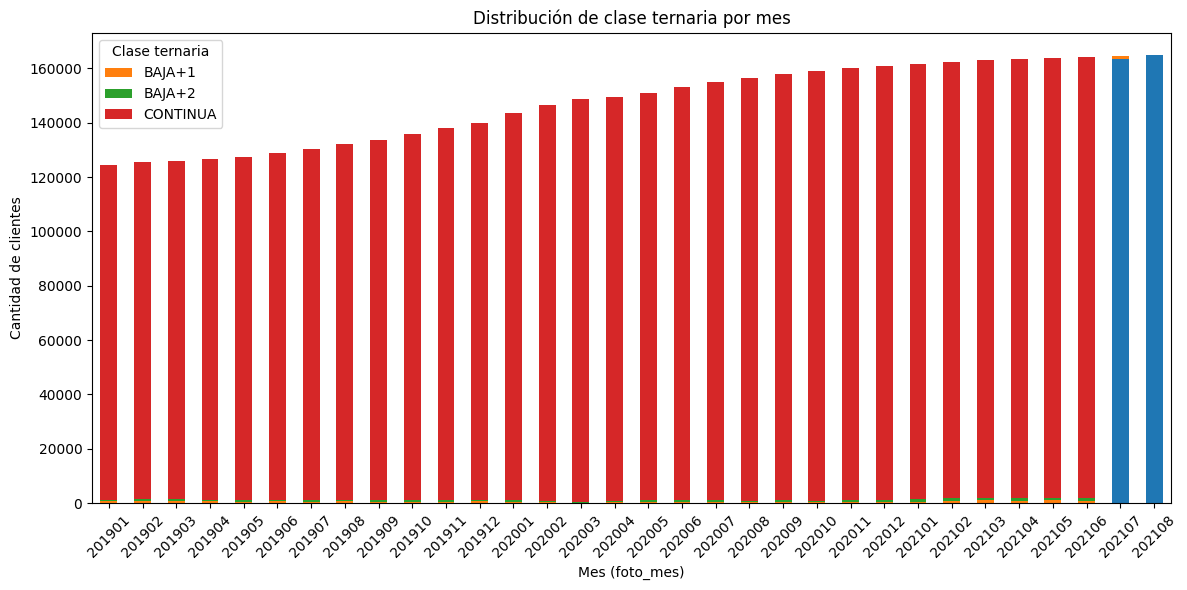

In [6]:
import matplotlib.pyplot as plt

# Contar la cantidad de registros por mes y clase
conteo = df.groupby(['foto_mes', 'clase_ternaria']).size().unstack(fill_value=0)

# Ordenar por mes (por si acaso)
conteo = conteo.sort_index()

# Graficar
conteo.plot(kind='bar', stacked=True, figsize=(12,6))

plt.title('Distribución de clase ternaria por mes')
plt.xlabel('Mes (foto_mes)')
plt.ylabel('Cantidad de clientes')
plt.legend(title='Clase ternaria')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


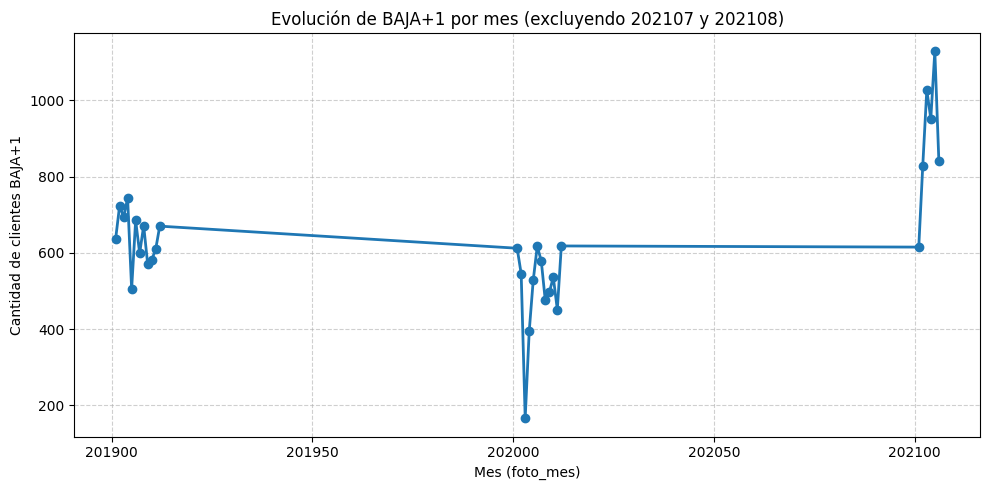

In [11]:
import matplotlib.pyplot as plt

# Asegurarnos de que foto_mes sea entero
df['foto_mes'] = df['foto_mes'].astype(int)

# Filtrar solo BAJA+1 y excluir 202107 y 202108
baja1 = (
    df[
        (df['clase_ternaria'] == 'BAJA+1') &
        (~df['foto_mes'].isin([202107, 202108]))
    ]
    .groupby('foto_mes')
    .size()
    .sort_index()
)

# Graficar
plt.figure(figsize=(10,5))
plt.plot(baja1.index, baja1.values, marker='o', linewidth=2)
plt.title('Evolución de BAJA+1 por mes (excluyendo 202107 y 202108)')
plt.xlabel('Mes (foto_mes)')
plt.ylabel('Cantidad de clientes BAJA+1')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


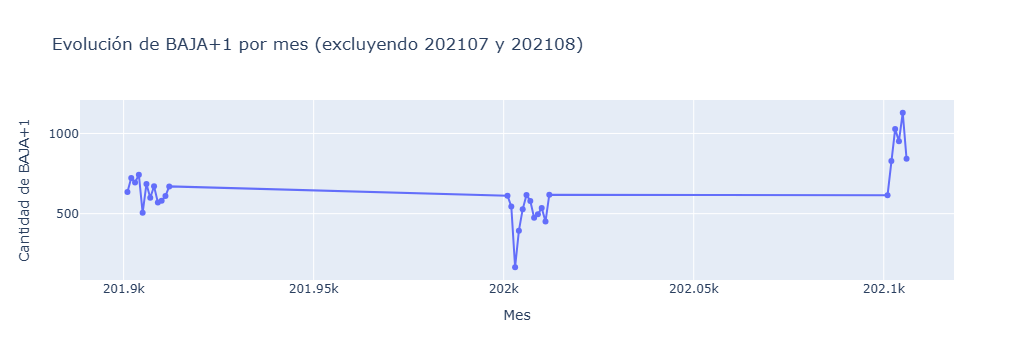

In [12]:
import plotly.express as px

# Asegurarnos de que foto_mes sea entero
df['foto_mes'] = df['foto_mes'].astype(int)

# Filtrar solo BAJA+1 y excluir 202107 y 202108
baja1 = (
    df[
        (df['clase_ternaria'] == 'BAJA+1') &
        (~df['foto_mes'].isin([202107, 202108]))
    ]
    .groupby('foto_mes')
    .size()
    .reset_index(name='cantidad')
    .sort_values('foto_mes')
)

# Graficar con Plotly
fig = px.line(
    baja1,
    x='foto_mes',
    y='cantidad',
    markers=True,
    title='Evolución de BAJA+1 por mes (excluyendo 202107 y 202108)',
    labels={'foto_mes': 'Mes', 'cantidad': 'Cantidad de BAJA+1'}
)

# Mostrar el gráfico interactivo
fig.show()


In [13]:
import pandas as pd

# Asegurarnos de que foto_mes sea entero
df['foto_mes'] = df['foto_mes'].astype(int)

# Filtrar solo BAJA+1 y excluir 202107 y 202108
baja1 = (
    df[
        (df['clase_ternaria'] == 'BAJA+1') &
        (~df['foto_mes'].isin([202107, 202108]))
    ]
    .groupby('foto_mes')
    .size()
    .reset_index(name='cantidad')
    .sort_values('foto_mes')
)

# Exportar a CSV
baja1.to_csv('baja1_por_mes.csv', index=False)

print("✅ Archivo 'baja1_por_mes.csv' exportado correctamente.")
print(baja1.head())


✅ Archivo 'baja1_por_mes.csv' exportado correctamente.
   foto_mes  cantidad
0    201901       635
1    201902       723
2    201903       694
3    201904       743
4    201905       505


In [15]:
import pandas as pd

# Asegurarnos de que foto_mes sea entero
df['foto_mes'] = df['foto_mes'].astype(int)

# Filtrar los meses válidos (excluyendo 202107 y 202108)
df_filtrado = df[~df['foto_mes'].isin([202107, 202108])]

# Contar BAJA+1 y BAJA+2 por mes
bajas = (
    df_filtrado[df_filtrado['clase_ternaria'].isin(['BAJA+1', 'BAJA+2'])]
    .groupby(['foto_mes', 'clase_ternaria'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .sort_values('foto_mes')
)

# Exportar a CSV
bajas.to_csv('bajas_por_mes.csv', index=False)

print("✅ Archivo 'bajas_por_mes.csv' exportado correctamente.")
print(bajas.head())


✅ Archivo 'bajas_por_mes.csv' exportado correctamente.
clase_ternaria  foto_mes  BAJA+1  BAJA+2
0                 201901     635     720
1                 201902     723     693
2                 201903     694     738
3                 201904     743     502
4                 201905     505     681


<Axes: >

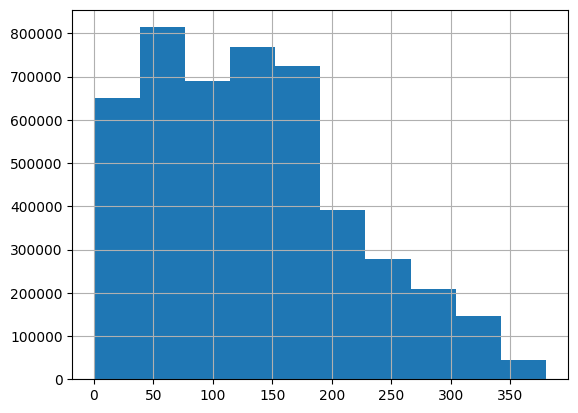

In [3]:
df["cliente_antiguedad"].hist()

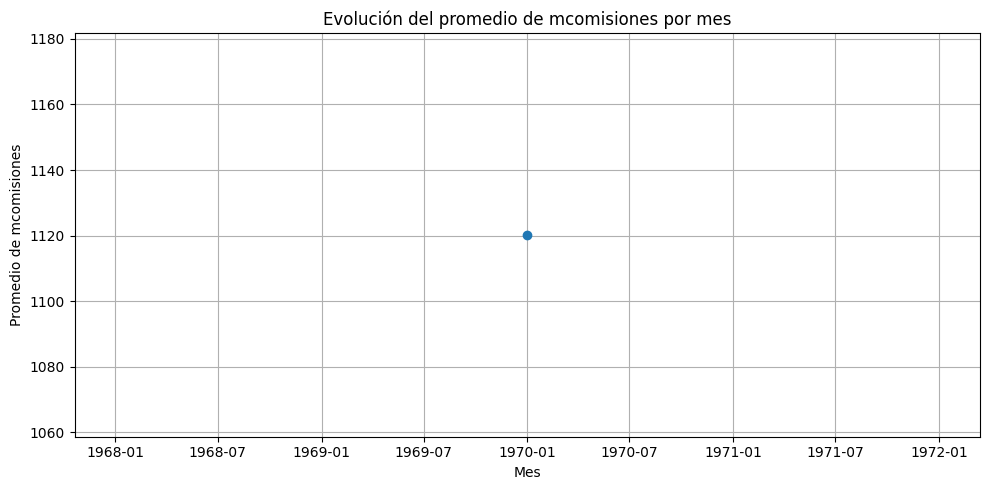

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Si 'fotomes' está en formato string, lo convertimos a fecha
df['foto_mes'] = pd.to_datetime(df['foto_mes'])

# Calculamos el promedio de mcomisiones por mes
promedio_mensual = (
    df.groupby(df['foto_mes'].dt.to_period('M'))['mcomisiones']
    .mean()
    .reset_index()
)

# Convertimos el período a timestamp para graficar
promedio_mensual['foto_mes'] = promedio_mensual['foto_mes'].dt.to_timestamp()

# Graficamos la evolución
plt.figure(figsize=(10, 5))
plt.plot(promedio_mensual['foto_mes'], promedio_mensual['mcomisiones'], marker='o')
plt.title('Evolución del promedio de mcomisiones por mes')
plt.xlabel('Mes')
plt.ylabel('Promedio de mcomisiones')
plt.grid(True)
plt.tight_layout()
plt.show()
